## National Vegetation Classification System (NVCS) Protection Summary by Management Category

This notebook is intended to provide code used in a summarization for NVCS classes for GAP Protected Areas Database (PAD) status levels 1, 2, and 3 across PAD mangement categories.
    
It utilizes an SQL server database assembled by intersecting numerous raster data layers created by the Gap Analysis Program including the PAD-US, species habitat maps, boundary layers such as states, counties, LCCs, ecoregions, etc. That database (the GAP Analytic database) at the time of this workflow development was only available on a local server. Hence, all code references a local instance of this database. This code is only replicable given access to a local instance of the database.

#### Accessing the local SQL server instance of the GAP Analytic database

In [1]:
import pyodbc
import pandas as pd
import numpy as np
import pandas.io.sql as psql
import seaborn as sns
import matplotlib.pyplot as plt


# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#            ++++ Directory Locations ++++
workDir = 'C:/Data/USGS Analyses/NVC-Analyses/Scripts/'


#############################################################################################
################################### LOCAL FUNCTIONS #########################################
#############################################################################################


## --------------Cursor and Database Connections--------------------

def ConnectToDB(connectionStr):
    '''
    (str) -> cursor, connection

    Provides a cursor within and a connection to the database

    Argument:
    connectionStr -- The SQL Server compatible connection string
        for connecting to a database
    '''
    try:
        con = pyodbc.connect(connectionStr)
    except:
        connectionStr = connectionStr.replace('11.0', '10.0')
        con = pyodbc.connect(connectionStr)

    return con.cursor(), con

## ----------------Database Connection----------------------

def ConnectAnalyticDB():
    '''
    Returns a cursor and connection within the GAP analytic database.
    '''
    # Database connection parameters
    dbConStr = """DRIVER=SQL Server Native Client 11.0;
                    SERVER=CHUCK\SQL2014;
                    UID=;
                    PWD=;
                    TRUSTED_CONNECTION=Yes;
                    DATABASE=GAP_AnalyticDB;"""

    return ConnectToDB(dbConStr)


#############################################################################################
#############################################################################################
#############################################################################################


In [2]:
## Connect to the Analytic Database
print("+"*45)
print("Connecting to Database ....")
cur, conn = ConnectAnalyticDB()

+++++++++++++++++++++++++++++++++++++++++++++
Connecting to Database ....


#### Generating an SQL string to pass to a pandas dataframe

In [3]:
## The SQL to pull out NVC Classes, PAD management and status data from the analytic db
sql = """


SELECT
	padus1_4.gap_sts as PADStatus,
	padus1_4.d_mang_nam as ManageName,
	padus1_4.d_mang_typ as ManageType,
	gap_landfire.nvc_class as NVCClass,
	--gap_landfire.nvc_group as NVCGroup,
	sum(lu_boundary_gap_landfire.count) as nCells
FROM	lu_boundary INNER JOIN lu_boundary_gap_landfire INNER JOIN gap_landfire
	ON	lu_boundary_gap_landfire.gap_landfire = gap_landfire.value
	ON	lu_boundary.value = lu_boundary_gap_landfire.boundary INNER JOIN padus1_4
	ON	lu_boundary.padus1_4 = padus1_4.objectid
GROUP BY
  padus1_4.d_mang_nam,
  padus1_4.d_mang_typ,
  padus1_4.gap_sts, 
  gap_landfire.nvc_class
  --gap_landfire.nvc_group

"""

#### Passing the SQL and getting a pandas dataframe

In [4]:
# Make a dataframe from the results of the SQL query
print("Creating Initial Dataframe ....")
df = psql.read_sql(sql, conn)

Creating Initial Dataframe ....


In [5]:
df

,PADStatus,ManageName,ManageType,NVCClass,nCells
0,4,National Park Service,State,Forest & Woodland,146
1,4,Army Corps of Engineers,Federal,Nonvascular & Sparse Vascular Rock Vegetation,74377
2,3,State Park and Recreation,State,"Polar & High Montane Scrub, Grassland & Barrens",164
3,3,Non-Governmental Organization,Non-Governmental Organization,Introduced & Semi Natural Vegetation,36020
4,1,U.S. Fish & Wildlife Service,Federal,Desert & Semi-Desert,9704019
5,4,Other or Unknown Federal Land,Federal,Nonvascular & Sparse Vascular Rock Vegetation,461
6,4,State Park and Recreation,State,Open Water,286418
7,3,City Land,Local Government,Nonvascular & Sparse Vascular Rock Vegetation,7761
8,1,Forest Service,Federal,Introduced & Semi Natural Vegetation,214440
9,1,Regional Water Districts,Regional Agency Special District,Agricultural & Developed Vegetation,71


#### Pull out only the natural/non-anthropogenic NVC classes

In [6]:
# Pull out only the natural/non-anthropogenic NVC classes
print("Removing Anthropogenic Classes ....")
df2 = df[(df['NVCClass'] == 'Forest & Woodland') | 
         (df['NVCClass'] == 'Shrub & Herb Vegetation') | 
         (df['NVCClass'] == 'Desert & Semi-Desert') | 
         (df['NVCClass'] == 'Polar & High Montane Scrub, Grassland & Barrens') | 
         (df['NVCClass'] == 'Open Rock Vegetation')]

Removing Anthropogenic Classes ....


#### Add a new column for area in square kilometers -- (ignore the Python warnings)

In [7]:
# Add a new column for area in square kilometers
print("Calculating Area in km2 ....")
df2['km2'] = df2['nCells']*0.0009

Calculating Area in km2 ....


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


#### Add a new column ManageCat that standarizes management types

In [8]:
# Add a new column ManageCat that standarizes management types
categories = {'Bureau of Land Management':'Bureau of Land Management',
'Forest Service':'Forest Service',
'National Park Service':'National Park Service',
'U.S. Fish & Wildlife Service':'U.S. Fish & Wildlife Service',
'American Indian Lands':'Other',
'City Land':'Other',
'County Land':'Other',
'Joint':'Other',
'Non-Governmental Organization':'Other',
'Other':'Other',
'Other or Unknown Local Government':'Other',
'Private':'Other',
'Regional Agency Land':'Other',
'Regional Water Districts':'Other',
'Unknown':'Other',
'Agricultural Research Service':'Other Federal',
'Army Corps of Engineers':'Other Federal',
'Bureau of Indian Affairs':'Other Federal',
'Bureau of Reclamation':'Other Federal',
'Department of Defense':'Other Federal',
'Department of Energy':'Other Federal',
'National Oceanic and Atmospheric Administration':'Other Federal',
'Other or Unknown Federal Land':'Other Federal',
'Tennessee Valley Authority':'Other Federal',
'Natural Resources Conservation Service':'Other Federal',
'Other or Unknown State Land':'State',
'State Department of Conservation':'State',
'State Department of Land':'State',
'State Department of Natural Resources':'State',
'State Fish and Wildlife':'State',
'State Land Board':'State',
'State Park and Recreation':'State'}
print("Adding a Management Category Column ....")
df2['ManageCat'] = df2['ManageName'].map(categories)

Adding a Management Category Column ....


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


#### Remove the PAD status 4 records and shorten the "Polar" class text

In [9]:
# Make a new dataframe excluding PAD status 4 records
df3 = df2[(df2['PADStatus'] != '4')]
# Shorten the class text 'Polar & High Montane Scrub, Grassland & Barrens'
#  to 'Polar & High Montane' for better plotting
df3['NVCClass'] = np.where(df3['NVCClass']==
   'Polar & High Montane Scrub, Grassland & Barrens',
   'Polar & High Montane', df3['NVCClass'])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


### Import the bokeh package for plotting and then start manipulating and organizing the data to prepare it as the data source for a bar chart figure

In [10]:
'''

    Plot stacked bar plots

'''
print("===== Begin Plotting =====")
# Using bokeh to plot with hierarchical labeling
from bokeh.core.properties import value
from bokeh.io import show, output_file
from bokeh.models import ColumnDataSource, FactorRange
from bokeh.plotting import figure
from bokeh.models import NumeralTickFormatter, HoverTool

# Bokeh generates an HTML file for the figure
output_file(workDir + "ManagementSummary.html")

===== Begin Plotting =====


In [11]:
# -----------------------------------------------------------------------------
# Manipulate the dataframe to organize data to use as the plotting source

# Add a Status column based on PAD Status to summarize area protection
print("  adding protection status column ...")
df3['Status'] = np.where(df3['PADStatus']=='3', 'Multiple Use', 'Protected')

# Drop PADStatus, ManageName, and nCellSum
df3 = df3.drop(['PADStatus','ManageName','nCells'], axis=1)
# There is no entry of 'Protected' (i.e. status 1 and/or 2) for Polar & High Montane
#   - 'Other Federal' in the data making the records for status pairs uneven.
#  Add a row that is 0 for these criteria
dfa = pd.DataFrame([['Polar & High Montane',0.0,'Other Federal','Protected']],
                   columns=['NVCClass','km2','ManageCat','Status'])
df3 = df3.append(dfa, ignore_index=True)

# Summarize protection area by category, class, and status
print("  summarizing by protection area by category, class and status ...")
dfSumKm = df3.groupby(by=['ManageCat','NVCClass','Status'])['km2'].sum().reset_index()
# Make a column of tupled category and class to index off
dfSumKm['CatCls'] = list(zip(dfSumKm['ManageCat'], dfSumKm['NVCClass']))
# Drop ManageCat and NVCClass columns
dfSumKm = dfSumKm.drop(['ManageCat','NVCClass'], axis=1)

# Pivot on Status and make the tupled category and class column the index
print("  pivoting on status column ...")
df4 = dfSumKm.pivot(index='CatCls', columns='Status', values='km2')
# Reorder columns
df4 = df4[['Protected', 'Multiple Use']]

# Reorder the rows using a preset order dictionary
print("  reordering rows ...")
sort = {('Bureau of Land Management', 'Forest & Woodland'):1,
('Bureau of Land Management', 'Shrub & Herb Vegetation'):2,
('Bureau of Land Management', 'Desert & Semi-Desert'):3,
('Bureau of Land Management', 'Polar & High Montane'):4,
('Bureau of Land Management', 'Open Rock Vegetation'):5,
('Forest Service', 'Forest & Woodland'):6,
('Forest Service', 'Shrub & Herb Vegetation'):7,
('Forest Service', 'Desert & Semi-Desert'):8,
('Forest Service', 'Polar & High Montane'):9,
('Forest Service', 'Open Rock Vegetation'):10,
('National Park Service', 'Forest & Woodland'):11,
('National Park Service', 'Shrub & Herb Vegetation'):12,
('National Park Service', 'Desert & Semi-Desert'):13,
('National Park Service', 'Polar & High Montane'):14,
('National Park Service', 'Open Rock Vegetation'):15,
('U.S. Fish & Wildlife Service', 'Forest & Woodland'):16,
('U.S. Fish & Wildlife Service', 'Shrub & Herb Vegetation'):17,
('U.S. Fish & Wildlife Service', 'Desert & Semi-Desert'):18,
('U.S. Fish & Wildlife Service', 'Polar & High Montane'):19,
('U.S. Fish & Wildlife Service', 'Open Rock Vegetation'):20,
('Other Federal', 'Forest & Woodland'):21,
('Other Federal', 'Shrub & Herb Vegetation'):22,
('Other Federal', 'Desert & Semi-Desert'):23,
('Other Federal', 'Polar & High Montane'):24,
('Other Federal', 'Open Rock Vegetation'):25,
('State', 'Forest & Woodland'):26,
('State', 'Shrub & Herb Vegetation'):27,
('State', 'Desert & Semi-Desert'):28,
('State', 'Polar & High Montane'):29,
('State', 'Open Rock Vegetation'):30,
('Other', 'Forest & Woodland'):31,
('Other', 'Shrub & Herb Vegetation'):32,
('Other', 'Desert & Semi-Desert'):33,
('Other', 'Polar & High Montane'):34,
('Other', 'Open Rock Vegetation'):35}

# Make a new dataframe by resetting the df4 index
df5 = df4.reset_index()
# Add the sortid column for sorting then sort
df5['sortid'] = df5['CatCls'].map(sort)
df5sort = df5.sort_values(by='sortid')
# Drop the sortid column then change the index back to CatCls
dfSource = df5sort.drop(['sortid'],axis=1)
dfSource = dfSource.set_index(keys=['CatCls'])
# Add a total km2 column
dfSource['Total Area'] = dfSource['Protected'] + dfSource['Multiple Use']

  adding protection status column ...
  summarizing by protection area by category, class and status ...
  pivoting on status column ...
  reordering rows ...


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


#### Configure the data and create an HTML file of the stacked bar chart

Note that the HTML file of the bar chart figure is interactive. There is a toolbar on the right side of the chart area.

In [12]:
# +++++++++++++++++++++++++++++++++++++++ Plotting +++++++++++++++++++++++++++++++++++++++++++++++++++
print("+++++ Sending Plot to HTML File +++++")
colors = ['#286000','#a6e883'] # Protected | Multiple Use
p = figure(title="Management by USNVC Class", plot_width=1100, x_range=FactorRange(*dfSource.index))

tt = HoverTool(
tooltips=[
    ("Protected", "@Protected{0,0}"),
    ("Multiple Use", "@{Multiple Use}{0,0}"),
    ("Total", "@{Total Area}{0,0}")
    ]
)

p.vbar_stack(dfSource.columns[0:2], x='CatCls', width=0.8, color=colors, 
             source=dfSource, legend=[value(x) for x in dfSource.columns[0:2]]) 

p.add_tools(tt)
p.title.align = "center"
p.title.text_font_size = '12pt'
p.legend.location = "top_center"
p.legend.orientation = "horizontal"
p.xaxis.major_label_orientation = 1.55
p.xaxis.axis_label_text_font_style = "normal"
p.y_range.start = 0
p.y_range.end = 150000
p.yaxis[0].formatter = NumeralTickFormatter(format="0,0")
p.yaxis.axis_label = "Square Kilometers"
p.yaxis.axis_label_text_font_style = "normal"

show(p)

+++++ Sending Plot to HTML File +++++


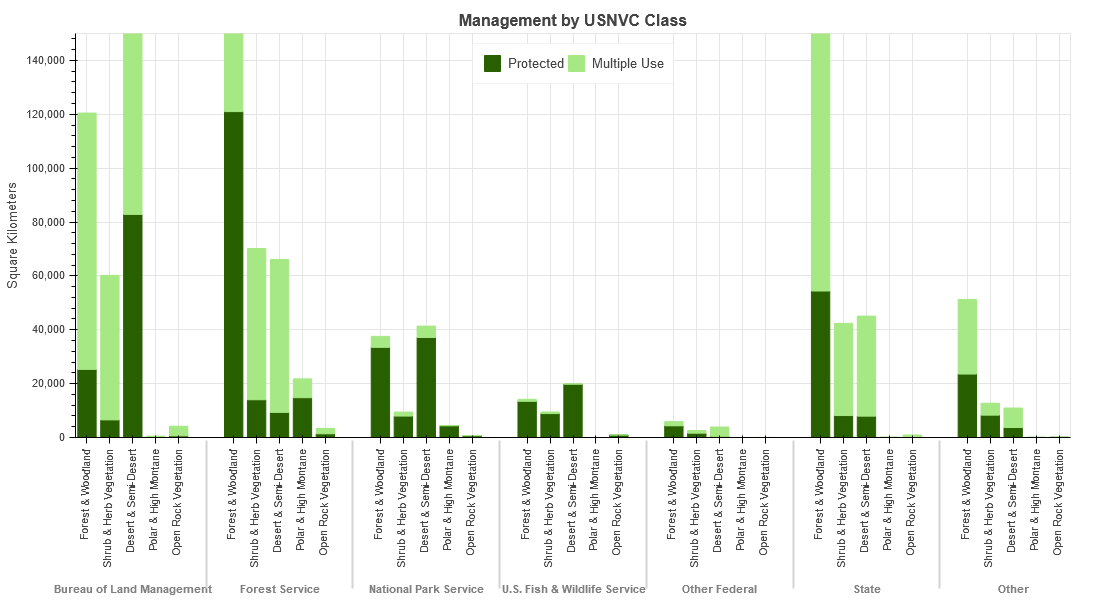

In [13]:
# The following will render the HTML file in the notebook using a local file source
from IPython.core.display import display, HTML, Image
#display(HTML(filename=workDir + "/ManagementSummary.html"))
# To display this on GitHub, render a screenshot image
repoDir = "C:/Data/USGS Analyses/NVC-Analyses"
display(Image(filename=repoDir + '/ManagementSummaryImage.png', embed=True))

With bokeh plots in HTML, tools can be added that allow the user to zoom, pan, save, and hover over elements to get more interactive information from the underlying data.

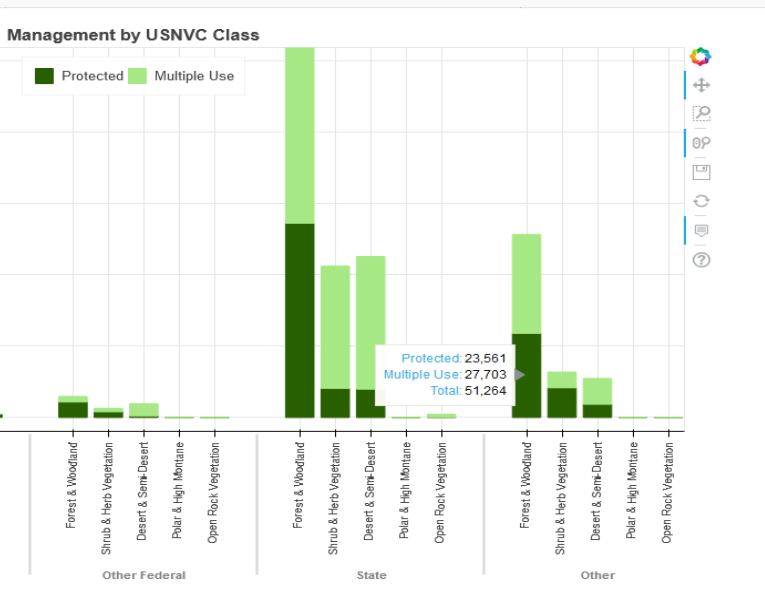

In [15]:
display(Image(filename=repoDir + '/BokehPlotZoom.png', embed=True))